<a href="https://colab.research.google.com/github/kayteeflick/nma_cn_flow_state/blob/cleaned_up_LFP_analysis/LFP_Coherence_and_Granger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow state notebook for coherence and granger analyses

This notebook shows the step by step processs of generating these analyses for the neuromatch academy summer 2021.  
Written by: Carlos Daniel Carrasco, UC Davis, 2021 

## Imports

In [18]:
#title 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt

In [3]:
# package needed to run Granger 
!pip install nitime
import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu
from nitime.viz import drawmatrix_channels

     |████████████████████████████████| 6.2 MB 7.7 MB/s 
  Created wheel for nitime: filename=nitime-0.9-cp37-cp37m-linux_x86_64.whl size=4032151 sha256=1c42108f410ed4a90282ab03fd948bbca271d463617ad3c9090a9975dfe7501f
  Stored in directory: /root/.cache/pip/wheels/8e/1b/71/d7d584087121ac331c444b913abeb116b527dad2a0f1d9157a
Successfully built nitime


## Data Retrieval - spikes

In [4]:
#title Data retrieval - spikes
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

## Data retrieval - LFP

In [5]:
 
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']


`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




## Functions

In [55]:
# commmon functions

def select_brois(data, brois, data_type, selection=True):
  '''
  Args:
    data: a numpy array of the Steinmetz 2019 data
    brois: a list of brain regions of interest
    data_type: "LFP" or "spikes"
    selection: if True, filters for sessions that contain all brois. If False, filters
        for sessions that contain any of the brois
  Returns:
    an embedded 1-d numpy array, with length = number of filtered session
  '''
  selected_data = np.array([])

  if data_type == "LFP":
    brain_area = "brain_area_lfp"
  elif data_type == "spikes":
    brain_area = "brain_area"

  if selection == True:
    for i in range(len(data)):
      if all(item in data[i][brain_area] for item in brois):
        selected_data = np.hstack((selected_data, data[i]))
  else:
    for i in range(len(data)):
      if any(item in data[i][brain_area] for item in brois):
        selected_data = np.hstack((selected_data, data[i]))

  return selected_data

def sel_neurons():
  print('todo')
  return

def spks_to_rate(spks):
  print('todo')
  return

def butter_bandpass_backend(lowcut, highcut, fs, order=6):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter_good_func(data, lowcut, highcut, fs, order=6):
  b, a = butter_bandpass_backend(lowcut, highcut, fs, order=order)
  y = filtfilt(b, a, data)
  return y 

def get_behavioral_idx(recording_session):
  '''
  Args:
    alldat: spiking data as loaded in originally 
    recording session: what recording session as an integer you want to pull behavioral indices for 
  Returns:
    series of arrays that you can use to index behavior 
  '''
  response = recording_session['response'] # right - nogo - left (-1, 0, 1)
  vis_right = recording_session['contrast_right'] # 0 - low - high
  vis_left = recording_session['contrast_left'] # 0 - low - high
  gocue_idx = recording_session['gocue']
  rt_idx = recording_session['reaction_time']
  is_correct = np.sign(response)==np.sign(vis_left-vis_right)
  return response, vis_right, vis_left, gocue_idx, rt_idx, is_correct

def concatenate_lfp(brain_area_raw_dat,zeropadsize=0): 
  '''
  Args:
    data: a 2d array of raw brain area LFP should be 2d after you select a specific session and area to pull. 
    zeropadsize: if you'd like to add padding to the concatenation. Default is 0 (no padding)
  Returns:
    1D Array of Concatenated trials for a given brain area recording. 
  '''
  concatenated_data = np.array([])
  N = zeropadsize
  for i in range(len(brain_area_raw_dat)):
    single_trial = brain_area_raw_dat[i,:]
    trial_padded = np.pad(single_trial,(N,N),'constant')
    concatenated_data = np.concatenate([concatenated_data,trial_padded])
  return concatenated_data

def spikes_avg(data):
  '''
  Args:
    data: a single session data frame from Steinmetz 2019 data
  Returns:
    A 2d numpy array of trial averages. Rows are neurons. Column are time step
  '''
  avg = np.mean(data['spks'], axis = 1)

  return avg

def add_avg(data):
  '''
  Adds the trial average to the data structure

  Args: 
    data: a single session dataframe from Steinmetz
  '''
  data["spks_avg"] = spikes_avg(data)
  return data

def multi_add_avg(alldat):
  """
  Adds trial averages to all sessions in the dataframe
  Args:
    alldat: a numpy array of sessions
  """
  for i in range(len(alldat)):
    alldat[i] = add_avg(alldat[i])
  return alldat

def concat_trials(data, bin_start, bin_end):
  """
  Args:
    data: a single session data frame from Steinmetz 2019 data
    bin_start, bin_end: integers indicating which bin to start and end at
  Returns:
    A 2d numpy array of with trials concatenated horizontally with shape N×TK 
    (number of neurons by number of time points times number of trials).
  """   
  NN = len(data['spks'][0])
  X = np.reshape(data['spks'][:,:,bin_start:bin_end], (NN,-1))

  return X

def trial_result(data):
  '''
  Args:
    data: a single session data frame
  Returns:
    numpy logical arrarys corresponding to right trials, correct right, incorrect
    right trials, miss right trials, no_go trials
  '''
  # response: right - nogo - left (-1, 0, 1)
  # vis left/right 0 - low - high
  response, vis_right, vis_left, gocue_idx, rt_idx, is_correct = get_behavioral_idx(data)
  ind = {}

  # trial types
  ind["right_go"] = np.array(vis_right > vis_left)
  ind["left_go"] = np.array(vis_left > vis_right)
  ind["nogo"] = np.logical_and(vis_left == 0, vis_right == 0)
  ind["equal"] = np.logical_and(vis_right >0, vis_right == vis_left)

  # right trials by response
  ind["right_cor"] = np.logical_and(response == -1, vis_right > vis_left)
  ind["right_error"] = np.logical_and(response == 1, vis_right > vis_left)
  ind["right_miss"] = np.logical_and(response == 0, vis_right > vis_left)

  # left trials by response
  ind["left_cor"] = np.logical_and(response == 1, vis_right < vis_left)
  ind["left_error"] = np.logical_and(response == -1, vis_right < vis_left)
  ind["left_miss"] = np.logical_and(response == 0, vis_right < vis_left)

  # nogo trials by response
  ind["nogo_cor"] = np.logical_and(response == 0, ind["nogo"])
  ind["nogo_error"] = np.logical_and(response != 0, ind["nogo"])

  return ind

def frequencyband_coherence_analysis(raw_dat,correct_idx,region_of_interest,timepoints,freq_band,corr):
  '''
  Args:
    raw_dat = array of LFP data for a specific session you would like to look at should be (brain_area,340,250)
    correct_idx = idx of correct or incorrect trials to look at one vector so dimension should match second dimension ie. len = 340 
    region_of_interest = (i = 1:12) what brain area you'd like to look at in a digit form. if using loop can go through all brain areas and do pair wise comparison. 
    timepoints =  (tp = [0,50]) what timepoints you'd like to run the coherence analysis over
    freq_band =  (fb = [5,8]) --> Theta, What frequence band you'd like to average coherence analysis over. 
  Returns:
    should return a vector for each comparison you chose to do. 
  '''

  coherence_array = np.empty((raw_dat.shape[0]))
  zeropadsize = 0 

  for i in range(raw_dat.shape[0]):

    if corr == 1:
      brain_area_1 = raw_dat[region_of_interest,correct_idx==1,timepoints[0]:timepoints[1]] # 1 is correct response
      brain_area_2 = raw_dat [i,correct_idx==1,timepoints[0]:timepoints[1]]
    else:
      brain_area_1 = raw_dat[region_of_interest,correct_idx==0,timepoints[0]:timepoints[1]] # 1 is correct response
      brain_area_2 = raw_dat [i,correct_idx==0,timepoints[0]:timepoints[1]]

    brain_area_1 = concatenate_lfp(brain_area_1,zeropadsize)
    brain_area_2 = concatenate_lfp(brain_area_2,zeropadsize)
    f, Cxy = signal.coherence(brain_area_1, brain_area_2, 100, nperseg=100)
    Cxy_avg = np.mean(Cxy[freq_band[0]:freq_band[1]])
    coherence_array[i] = Cxy_avg

  return coherence_array


def granger_causality_analysis(averaged_data,TR,freq_band): 
  '''
  Args:
    averaged_data = array of averaged LFP Data over a specific ROI and then the timeseries should look like if taking all brain regions (12,250)
    TR = the sampling rate of your signal in seconds, for our case this is .01 = 100 hz = 10 ms 
    freq_band = the lower and upper frequency bands you'd like to look at [5,8] for theta . 
  Returns:
    G which is a granger class with a bunch of different parameters related to your analysis including causality metric.
    g2 which is a form of granger where we are examing the difference between Fx→y and Fy→x to get a clearer understanding of which is leading. 
  '''
  f_ub = freq_band[1]
  f_lb = freq_band[0]
  pdata = tsu.percent_change(averaged_data)
  time_series = ts.TimeSeries(pdata, sampling_interval=TR)
  G = nta.GrangerAnalyzer(time_series, order=1)
  freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]
  g2 = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G], -1)
  return G, g2


def get_high_firing_spikes(spike_data, min_rate, sr=100):
  '''
  Takes spike data and returns only the neurons with a high enough firing rate
  averaged across all trials/time

  Parameters
  --------------------------------
  spike_data : 3d array of spikes with dimensions (neurons, trials, time)
  min_rate : The firing rate to filter above (in spikes/sec)
  sr : sampling rate of data

  Returns
  --------------------------------
  spikes_subset : 3d array of spikes with dimensions (neurons (filtered), trials, time)
  '''
  spike_counts = np.sum(np.reshape(spike_data, (spike_data.shape[0], -1)), axis=1)
  total_time = spike_data.shape[1] * spike_data.shape[2] / sr
  spike_rate = spike_counts / total_time
  spikes_subset = spike_data[spike_rate > min_rate]
  return(spikes_subset)


#LFP Coherence Analysis 

In [45]:
#@title Pulling relevant indices 
temp_dat = alldat[11]
idx = trial_result(temp_dat) 
print(idx.keys())
# don't have enough right error trials so collapsing across errors 
no_go_error = idx['nogo_error']
right_error = idx['right_error']
no_go_error = no_go_error.astype('uint8')
right_error = right_error.astype('uint8')
#Indices of interest 
correct_right_idx = idx['right_cor']#only at correct trials and for regions of interest
error_idx = right_error + no_go_error


dict_keys(['right_go', 'left_go', 'nogo', 'equal', 'right_cor', 'right_error', 'right_miss', 'left_cor', 'left_error', 'left_miss', 'nogo_cor', 'nogo_error'])


In [46]:
#@title Running coherence @ Theta Right and Incorrect Trials 
#pulling data and idx of interest
session11 = dat_LFP[11]
session11_lfp = session11['lfp']
session11_lfp_roi = np.delete(session11_lfp,[0,8,9],axis=0)
#parameters 
timepoints = [0,50]
fb = [5,8]

#running analysis 
theta_array = np.empty([9,9])
theta_array_incorr = np.empty([9,9])
for i in range(theta_array.shape[0]): 

  theta_array[i,:] = frequencyband_coherence_analysis(session11_lfp_roi,correct_right_idx,i,timepoints,fb,1)
  theta_array_incorr[i,:] = frequencyband_coherence_analysis(session11_lfp_roi,error_idx,i,timepoints,fb,1)

Text(0.5, 1.0, 'Theta Coherence Right Correct Trials Pre Stim')

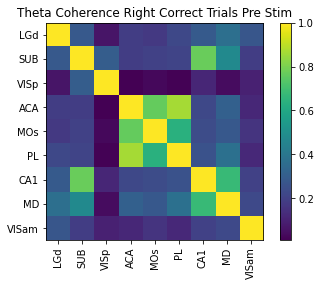

In [47]:
#@title Plotting Right Correct Coherence 
positions = (0,1, 2, 3,4,5,6,7,8)
labels = session11['brain_area_lfp']
roi_labels = np.delete(labels,[0,8,9])
plt.xticks(positions, roi_labels,rotation = 'vertical')
plt.yticks(positions, roi_labels)
plt.imshow(theta_array)
plt.colorbar()
plt.title('Theta Coherence Right Correct Trials Pre Stim')


Text(0.5, 1.0, 'Theta Coherence Incorrect Trials Pre Stim')

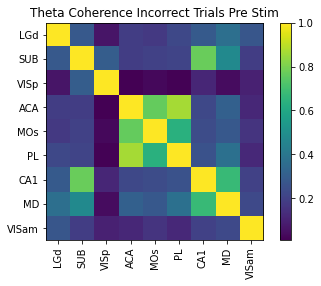

In [48]:
#@title Plotting Error 
positions = (0,1, 2, 3,4,5,6,7,8)
plt.xticks(positions, roi_labels,rotation = 'vertical')
plt.yticks(positions, roi_labels)
plt.imshow(theta_array)
plt.colorbar()
plt.title('Theta Coherence Incorrect Trials Pre Stim')

Text(0.5, 1.0, 'Theta Coherence Corr - Incorr: -500 - 0 ms')

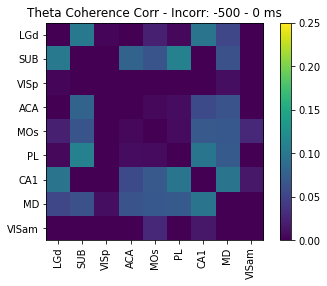

In [49]:
#@title Difference matrix Correct - Incorrect 
difference_coherence = np.subtract(theta_array,theta_array_incorr)
plt.imshow(difference_coherence)
positions = (0,1, 2, 3,4,5,6,7,8)
plt.xticks(positions, roi_labels,rotation = 'vertical')
plt.yticks(positions, roi_labels)
plt.colorbar()
plt.clim(0,.25) 
plt.title('Theta Coherence Corr - Incorr: -500 - 0 ms')

#Granger Causality Analysis

In [56]:
#@title Prepping Averaged Data 
session11_lfp_corr = session11_lfp[:,correct_right_idx==1,:] # pulling correct trials only 
session11_lfp_incorr = session11_lfp[:,error_idx==1,:] #pulling incorrect trials only 
session11_lfp_corr_avg = np.mean(session11_lfp_corr,axis=1) #averaging 
session11_lfp_incorr_avg = np.mean(session11_lfp_incorr,axis=1)


In [57]:
#@title Running Grangers 
TR = .01 #time res 100 hz = 10 ms  
fb = [5,8] # theta band 

G_corr, g2_corr = granger_causality_analysis(session11_lfp_corr_avg,TR,freq_band=fb)
G_incorr, g2_incorr = granger_causality_analysis(session11_lfp_incorr_avg,TR,freq_band=fb)

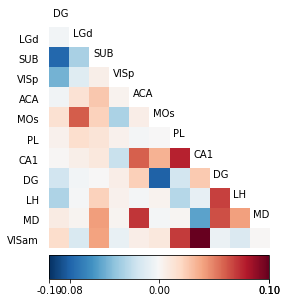

In [67]:
#@title Plotting Correct Right Granger
fig01 = drawmatrix_channels(np.transpose(g2_corr), labels, size=[5., 5.], color_anchor=0)

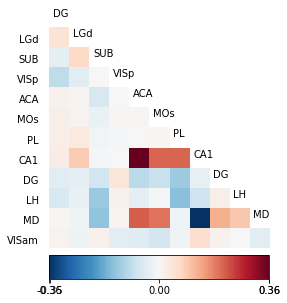

In [68]:
#@title Plotting Error Granger 
fig02 = drawmatrix_channels(np.transpose(g2_incorr), labels, size=[5., 5.], color_anchor=0)

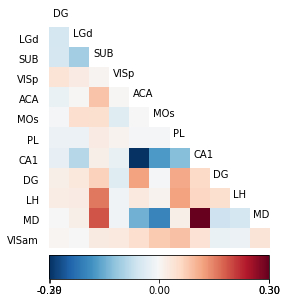

In [70]:
#@title Plotting Difference Granger 
g2_diff = np.subtract(g2_corr,g2_incorr)
fig03 = drawmatrix_channels(np.transpose(g2_diff), labels, size=[5., 5.], color_anchor=0)